# Выявление причин убыточности развлекательного приложения Procrastinate Pro+

**Цель исследования** - выявить причины убыточности развлекательного приложения Procrastinate Pro+.

**Ход исследования** - информация с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузку их покупок за период, а также статистику рекламных расходов получена из лога сервера. Для выявления причин убыточности бизнеса требуется изучить поведение пользователей:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

**Описание данных**:

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

Этапы исследования:
1. [Шаг 1. Загрузка данных и подготовка их к анализу](#general_id)
2. [Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии](#step_two)
3. [Шаг 3. Исследовательский анализ данных](#step_three)
4. [Шаг 4. Маркетинг](#step_four)
5. [Шаг 5. Оцените окупаемость рекламы для привлечения пользователей](#step_five)
   <br> 5.1 [Анализ общей окупаемости рекламы](#step_five_one)
   <br> 5.2 [Анализ окупаемости рекламы с разбивкой по устройствам](#step_five_two)
   <br> 5.3 [Анализ окупаемости рекламы с разбивкой по странам](#step_five_three)
   <br> 5.4 [Анализ окупаемости рекламы с разбивкой по рекламным каналам]((#step_five_four)
6. [Общий вывод](#conclusion_id)

## Шаг. Загрузка данных и подготовка их к анализу
<a id=general_id></a>


In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

Создадим функцию research для изучения данных в таблице.

In [3]:
def research (data):
    data.info(memory_usage='deep')
    display(data.head())
    display(data.describe())
    print('Количество дубликатов',data.duplicated().sum())

Изучим таблицу visits

In [4]:
research(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 104.9 MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


Количество дубликатов 0


In [5]:
visits=visits.rename(columns={'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start','Session End':'session_end'})
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])

Изучим таблицу orders

In [7]:
research(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5 MB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


Количество дубликатов 0


In [8]:
orders=orders.rename(columns={'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})

In [9]:
orders['event_dt']=pd.to_datetime(orders['event_dt'])

Изучим таблицу costs

In [10]:
research(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 251.5 KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


Количество дубликатов 0


In [11]:
costs=costs.rename(columns={'Channel':'channel'})

In [12]:
costs['dt']=pd.to_datetime(costs['dt']).dt.date

### Вывод

Из лога сервера были получены и загружены 3 датасета:
- visits отражена информация по посещениям пользователей (регион, устройство, уникальный номер пользователя, дата начала сессии и дата окончания сессии, рекламный источник);
- orders отражена информация по приобретениям пользователей (уникальный номер пользователей, выручка и дата совершения покупки);
- costs отражена информация по расходам на рекламу(дата, источник, затраты за день)

В таблицах отсутствуют пропуски, дубликаты, типы данные указаны верно во всех таблицах верно, кроме дат (по ним формат изменен на формат даты).Наименование колонок было задано с ошибками, наименования были приведены к нижнему регистру и пробелы заменены на "_".

## Шаг. Функции для расчета и анализа LTV, ROI, удержания и конверсии
<a id=step_two></a>

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [13]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]').dt.month

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [15]:
# функция для  расчета конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [17]:
# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


### Вывод

В рамках 2 шага были заданы функции для:
- создания пользовательских профилей;
- расчёта удержания;
- расчета конверсии;
- LTV и ROI

## Шаг. Исследовательский анализ данных
<a id=step_three></a>
Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Построим таблицу с профилями пользователей, с помощью функции get_profiles.

In [18]:
profiles=get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt  month  payer  acquisition_cost  
0  2019-05-07      5   True          1.088172  
1  2019-07-09      7  False          1.107237  
2  2019-10-01     10  False          0.000000  
3  2019-08-22      8  False          0.988235  
4  2019-10-02     10  False          0.230769  


In [19]:
min_date=profiles['first_ts'].min()
max_date=profiles['first_ts'].max()

print('Минимальная дата привлечения пользователей:',min_date)
print('Максимальная дата привлечения пользователей:',max_date)

Минимальная дата привлечения пользователей: 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


При условии,что окупаемость рекламной кампании должна наступать не позднее чем через 2 недели после привлечения пользователей, горизонт анализа составит 14 дней. В связи с этим для проведения анализа требуется взять данные за период с 01.05.2019 по 14.10.2019 включительно, так как по всем пользователям привлеченным после этой даты не будет аналитики. 

Определим из каких стран приходят посетители.

In [20]:
region=(
    profiles
    .groupby('region')
    .agg({'payer':['count','mean']})
    .sort_values(by='region',ascending=False)
    .rename(columns={'count':'Количество пользователей','mean':'% Платящих'})
    .style.format({'Количество пользователей':'{:.0f}','% Платящих':'{:.2% }'})
    
    

)
display(region)

Определим с каких устройств пользователи чаще заходят

In [21]:
device=(
    profiles
    .groupby('device')
    .agg({'payer':['count','mean']})
    .sort_values(by='device',ascending=False)
    .rename(columns={'count':'Количество пользователей','mean':'% Платящих'})
    .style.format({'Количество пользователей':'{:.0f}','% Платящих':'{:.2% }'})
    
    

)
display(device)

Определим каналы привлечения пользователей

In [22]:
channel=(
    profiles
    .groupby('channel')
    .agg({'payer':['count','mean']})
    .sort_values(by='channel',ascending=False)
    .rename(columns={'count':'Количество пользователей','mean':'% Платящих'})
    .style.format({'Количество пользователей':'{:.0f}','% Платящих':'{:.2%}'})
    
    

)
display(channel)

### Вывод

Пользователи нашего приложения в основном граждане **United States** (100 002 человека) меньшую часть занимают граждане **UK,France,Germany**.Самый высокий процент платящих пользователей в United States и составили 6,90%.

Самым популярным девайсом является **iPhone**,менее популярным девайсом выступает **Android**, последние позициии занимают пользователи Mac и PC. Платящих пользователей больше у владельцев iPhone и Mac 6,2% и 6,4% соответственно.

В 3 ку лидеров по **каналам привлечения вошли**:
- organic - 56439
- FaceBoom - 29144
- TipTop - 19561

Привлечение бесплатного трафика - это хорошо,но высокий процент платящих пользователей приходится на канал TipTop и RocketSuperAds.

## Шаг. Маркетинг
<a id=step_four></a>
Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [23]:
total=profiles['acquisition_cost'].sum()
print("Всего израсходовано на рекламу: {:.0f}".format(total))

Всего израсходовано на рекламу: 105497


In [24]:
total_by_source=(
    profiles
    .groupby('channel')
    .agg({'acquisition_cost':'sum'})
    .sort_values(by='acquisition_cost',ascending=False)
    .rename(columns={'sum':'Сумма расходов на рекламу'})
    .reset_index()
    .style.format({'Сумма расходов на рекламу':'{:.0f}'})
)

print('Потрачено на каждый источник рекламы')
display(total_by_source)

Потрачено на каждый источник рекламы


,channel,acquisition_cost
0,TipTop,54751.300000
1,FaceBoom,32445.600000
2,WahooNetBanner,5151.000000
3,AdNonSense,3911.250000
4,OppleCreativeMedia,2151.250000
5,RocketSuperAds,1833.000000
6,LeapBob,1797.600000
7,lambdaMediaAds,1557.600000
8,MediaTornado,954.480000
9,YRabbit,944.220000


In [25]:
total_by_month=(
    profiles
    .groupby('month')
    .agg({'acquisition_cost':'sum'})
    .sort_values(by='acquisition_cost',ascending=False)
    .rename(columns={'sum':'Сумма расходов на рекламу'})
    .reset_index()
    .style.format({'Сумма расходов на рекламу':'{:.0f}'})
)

print('Сумма расходов на рекламу по мес.')
display(total_by_month)

Сумма расходов на рекламу по мес.


,month,acquisition_cost
0,9,22441.340000
1,10,20882.415000
2,8,20657.870000
3,7,16447.060000
4,6,15090.045000
5,5,9978.570000


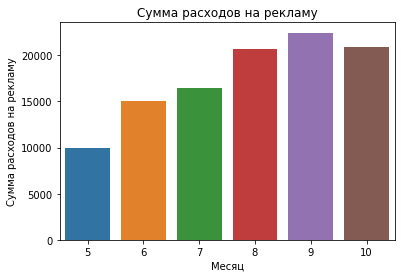

In [26]:

ax = sns.barplot(x="month", y="acquisition_cost",data=profiles.query('channel != "organic"').groupby('month')['acquisition_cost'].sum().reset_index()) 
plt.rcParams['figure.figsize']=10,5

plt.title('Сумма расходов на рекламу')
plt.ylabel('Сумма расходов на рекламу')
plt.xlabel('Месяц')
plt.show()
 

In [27]:
result = (
        profiles
        .query('channel != "organic"')
        .pivot_table(index='channel', columns='month', values='acquisition_cost', aggfunc='sum')
)
    


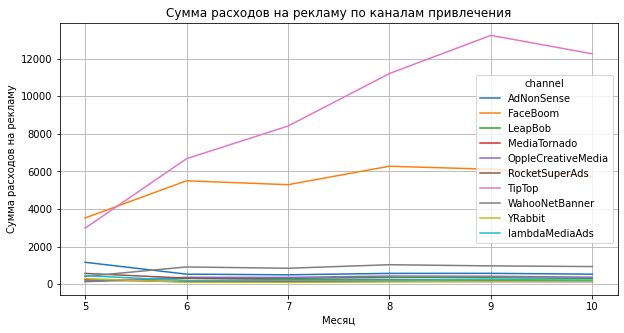

In [28]:
result.T.plot(grid=True, figsize=(10, 5), 
             # xticks=['channel']
             )

plt.title('Сумма расходов на рекламу по каналам привлечения')
plt.ylabel('Сумма расходов на рекламу')
plt.xlabel('Месяц')
plt.show()


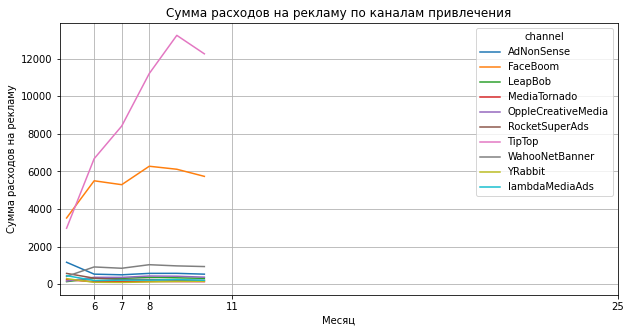

In [29]:
# ячейка ревьюера:
result.T.plot(grid=True, figsize=(10, 5), 
              xticks=([6,7,8,11,25])
             )
plt.title('Сумма расходов на рекламу по каналам привлечения')
plt.ylabel('Сумма расходов на рекламу')
plt.xlabel('Месяц')
plt.show()

In [30]:
total_by_source=(
    profiles
    .query('channel != "organic"')
    .groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values(by='acquisition_cost',ascending=False)
    .rename(columns={'acquisition_cost':'Средняя сумма расходов на рекламу'})
    .reset_index()
    .style.format({'Средняя сумма расходов на рекламу':'{:.2f}'})
)
print()
print('Средняя стоимость привлечения клиентов по источникам')
print()
display(total_by_source)
print()
print('Средняя стоимость привлечения клиентов: {:.1f}'.format(profiles.query('channel != "organic"')['acquisition_cost'].mean()))
print()



Средняя стоимость привлечения клиентов по источникам



,channel,Средняя сумма расходов на рекламу
0,TipTop,2.80
1,FaceBoom,1.11
2,AdNonSense,1.01
3,lambdaMediaAds,0.72
4,WahooNetBanner,0.60
5,RocketSuperAds,0.41
6,OppleCreativeMedia,0.25
7,YRabbit,0.22
8,MediaTornado,0.22
9,LeapBob,0.21



Средняя стоимость привлечения клиентов: 1.1



In [31]:
print('Средняя стоимость привлечения клиентов: {:.1f}'.format(profiles.query('channel != "organic"')['acquisition_cost'].mean()))

Средняя стоимость привлечения клиентов: 1.1


### Вывод

**Всего** на рекламные расходы было потрачено **105 497 USD.**

Большая часть расходов приходится на **TipTop 54 751.3 и FaceBoom 32 445.6**, намного меньше потрачено на WahooNetBanner,AdNonSense,OppleCreativeMedia (расходы составили менее 2000).

Расходы на рекламу плавно увеличиваются с мая и достигают своего пика в сентябре, в октябре наблюдается небольшое снижение.

**Средняя стоимость привлечения Клиента** за весь период составила **0.70 CAC**.

Самым дорогим каналом по привлечению Клиентов является TipTop, его стоимость за привлечение одного пользователя составила 2.8.
На уровне 1-1.11 расходы по FaceBoom и AdNonSense, остальные каналы обходятся меньше 1.




## Шаг. Оценка окупаемости рекламы для привлечения пользователей
<a id=step_five></a>

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Анализ  общей окупаемости рекламы
<a id=step_five_one></a>

In [32]:
##Рассчитаем LTV и ROI, исключив бесплатный канал привлечения organic
horizon_days=14

ltv_raw,ltv,ltv_history,roi,roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=[],
    ignore_horizon=False,
)

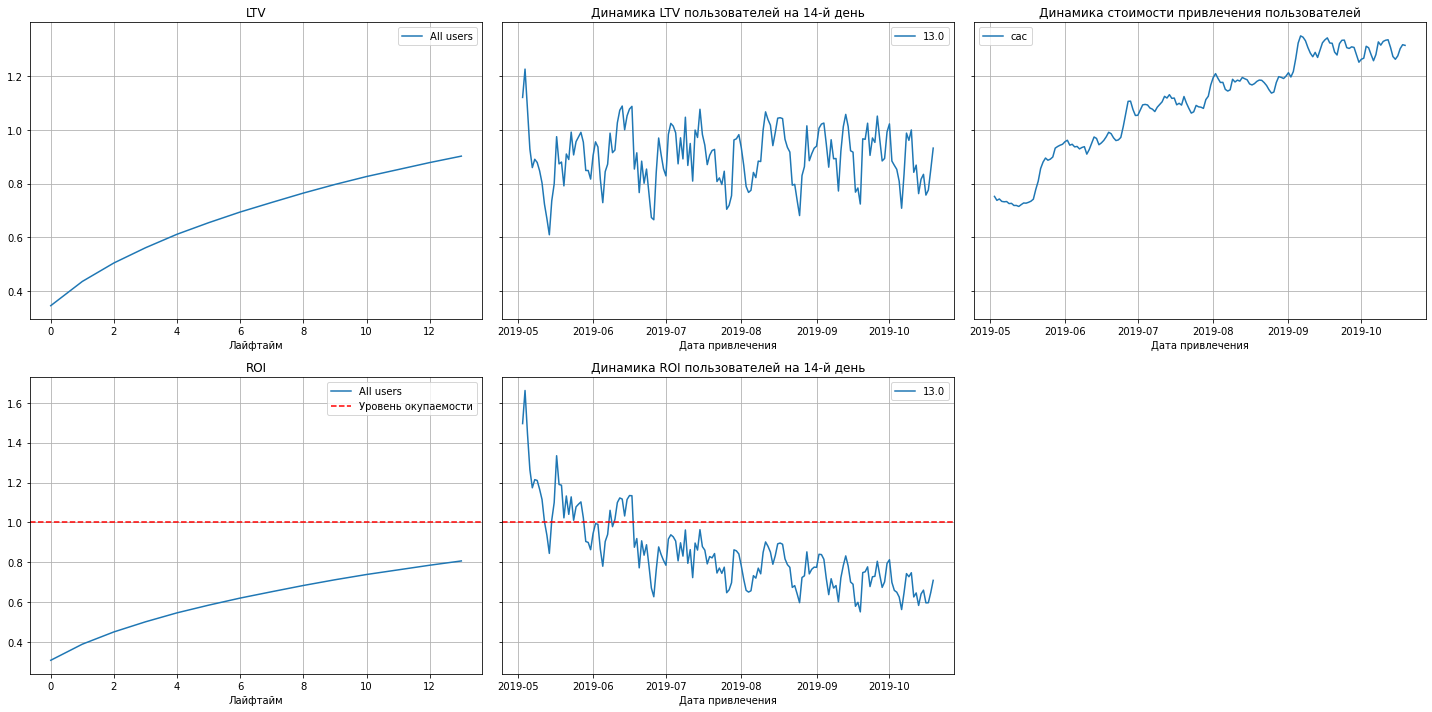

In [33]:
events = None  # других событий нет

# построим графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

#### Вывод
- Уровень LTV растет и на 14 дней достигает ~ 0.9. В динамике мы наблюдаем сезонное изменение LTV, на начало и конец периода показатель дерижтся примерно на том же уровне. Следовательно количество привлеченных пользователей сильно не меняется,
- Показатель CAC сильно увеличился,это означает,что стоимость рекламы стала дороже, при текущей динамике LTV и увеличении CAC выше ~ 0.8 рекламная кампания становится нерентабельной,о чем свидетельствует динамика ROI. Исходя из графика ROI можно сделать вывод,что кампания по данному приложению была неэффективной и принесла убыток.


### Анализ окупаемости рекламы с разбивкой по устройствам

<a id=step_five_two></a>

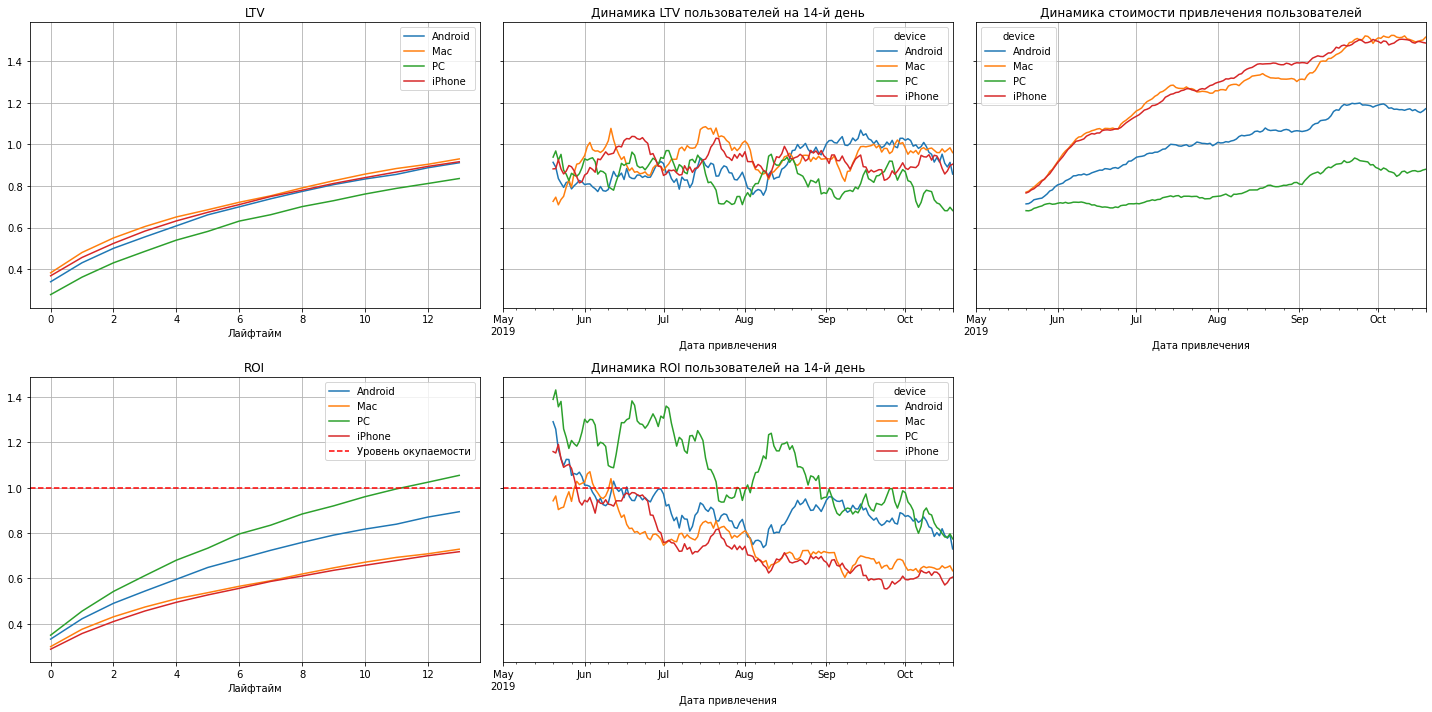

In [34]:
##Рассчитаем LTV и ROI, исключив бесплатный канал привлечения organic
horizon_days=14

ltv_raw,ltv,ltv_history,roi,roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['device'],
    ignore_horizon=False,
)
events = None  # других событий нет

# построим графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=20)

#### Вывод
- Уровень LTV растет и на 14 дней достигает ~ 0.9. В динамике мы наблюдаем сезонное изменение LTV, на начало и конец периода показатель дерижтся примерно на том же уровне по всем устройствам, кроме PC. Следовательно количество привлеченных пользователей сильно не меняется, следует проверить приложение на предмет технических ошибок по дейвайсу PC.
- Самый высокий показатель CAC мы наблюдаем на дейвайсах MAC и  Iphone, по этим девайсам расходы на рекламу растут намного стремительнее, следует изучить природу подобных изменений.
- Из всех дейвайсов рекламная кампания окупается только по PC, динамика окупаемости к концу периода ухудшается по всем пользователям.

### Анализ окупаемости рекламы с разбивкой по странам
<a id=step_five_three></a>

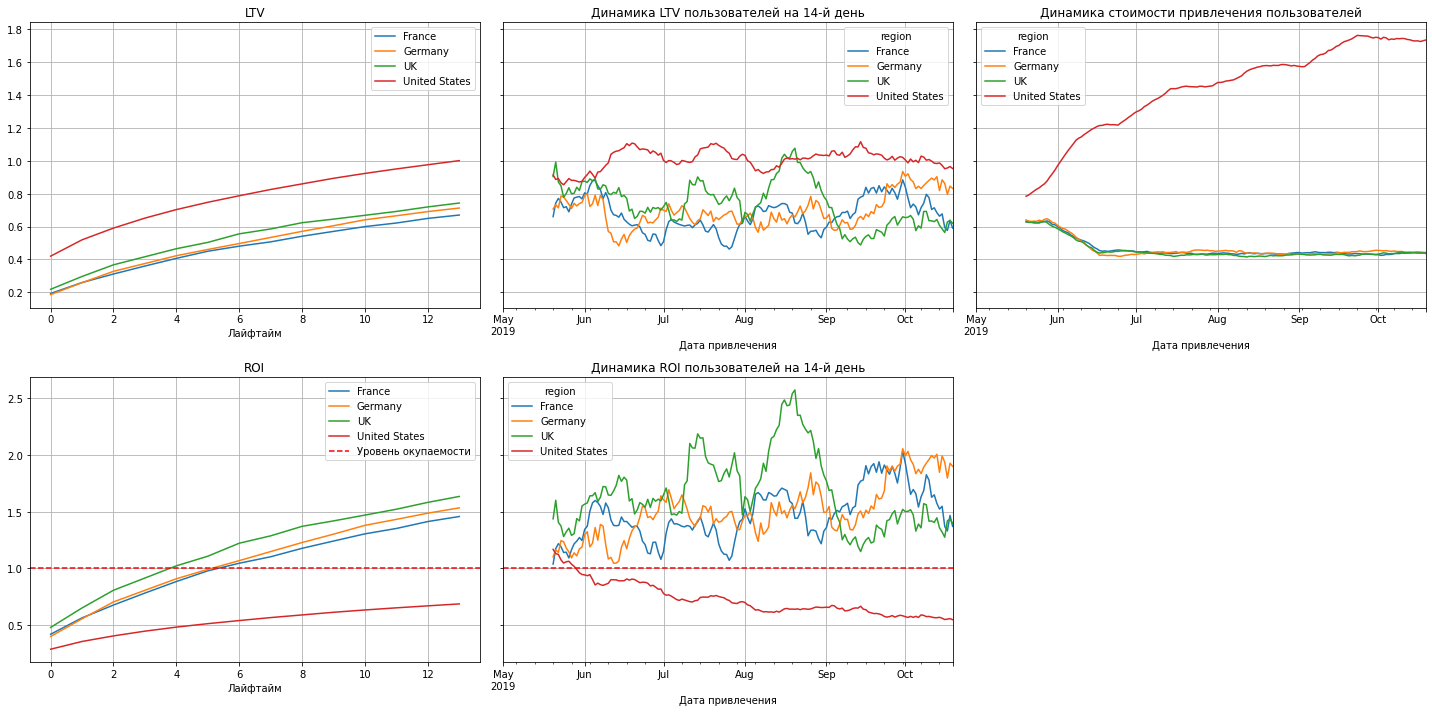

In [35]:
##Рассчитаем LTV и ROI, исключив бесплатный канал привлечения organic
horizon_days=14

ltv_raw,ltv,ltv_history,roi,roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['region'],
    ignore_horizon=False,
)
events = None  # других событий нет

# построим графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=20)

#### Вывод
Исходя из визуализаций по регионам сразу становится понятно с чем связана низкая рентабельность по девайсам MAC и Iphone. Основными пользователями данных дейвайсов являются граждане USA. Хоть и доход по всем странам динамично растет, также растут расходы на рекламу,что приводит к превышению доходов над расходами по USA. По остальным странам рекламная кампания эффективна и имеет довольно неплохой уровень окупаемости ~ 1.5


### Анализ окупаемости рекламы с разбивкой по рекламным каналам
<a id=step_five_four></a>

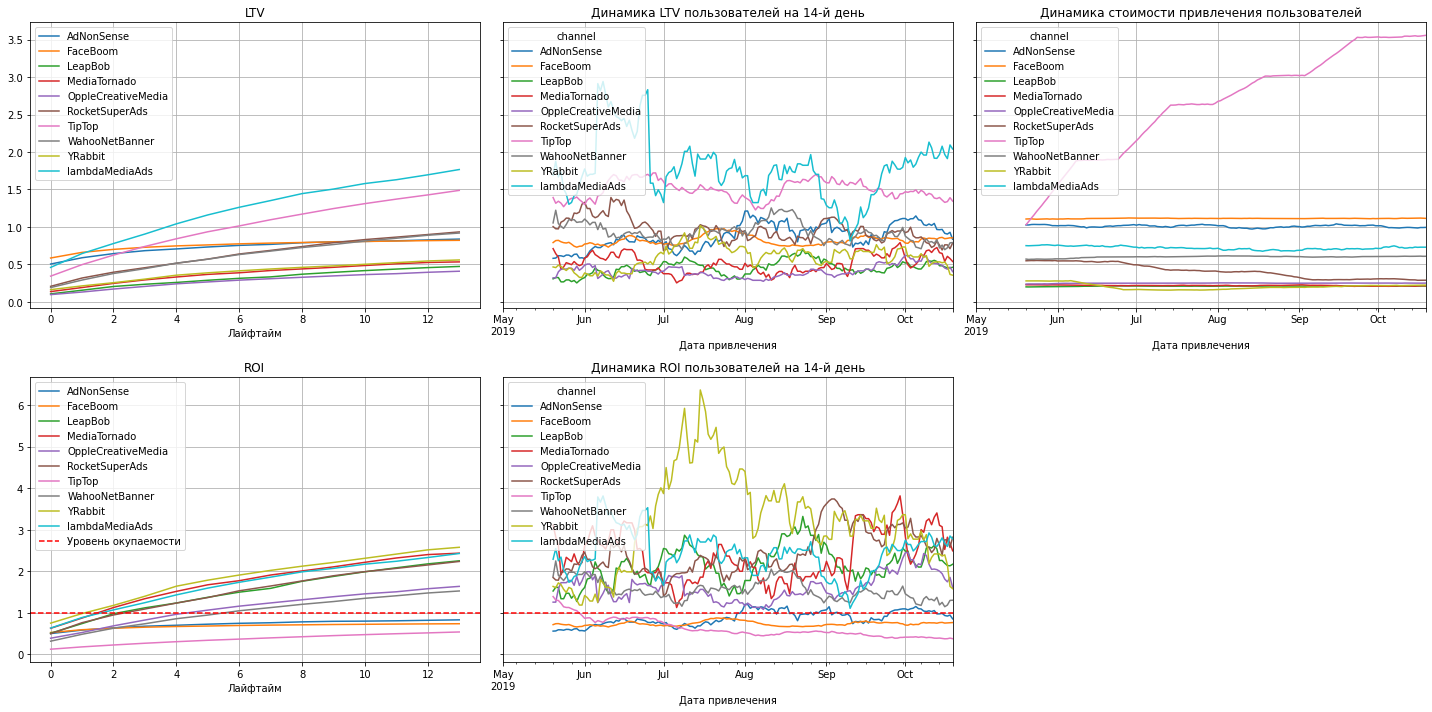

In [36]:
##Рассчитаем LTV и ROI, исключив бесплатный канал привлечения organic
horizon_days=14

ltv_raw,ltv,ltv_history,roi,roi_history = get_ltv(
    profiles.query('channel != "organic"'),
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel'],
    ignore_horizon=False,
)
events = None  # других событий нет

# построим графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=20)

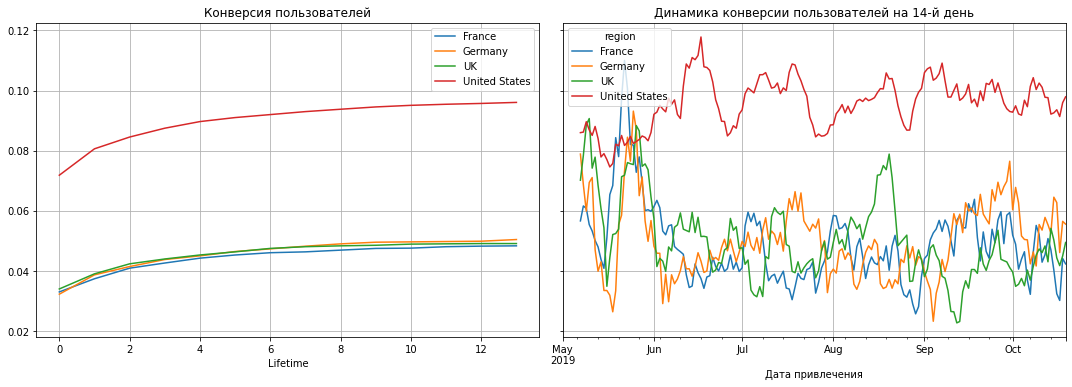

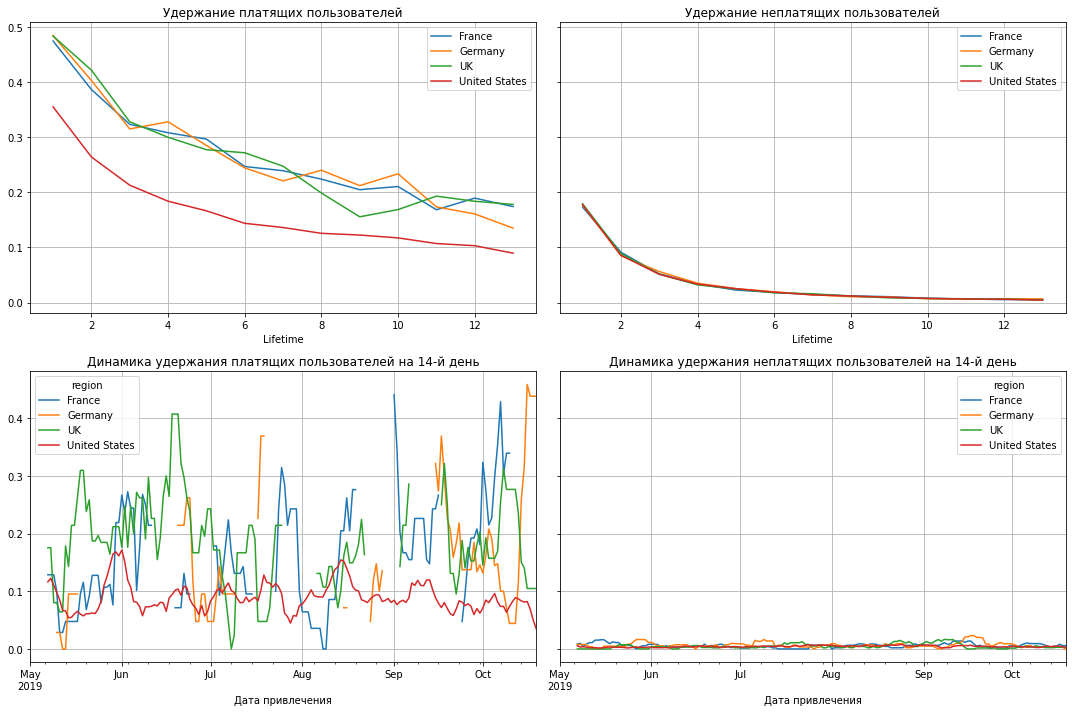

In [37]:
# Ячейка ревьюера:

def plot_retention(retention, retention_history, horizon, window = 7):
    
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (15, 10))
    
    # проверим размер индекса - если в нем только один столбец payer, 
    # то добавим еще один - иначе функция будет ломаться
    # такую процедуру мы с вами делали для расчета конверсии и ltv
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users' 
        retention = retention.reset_index().set_index(['cohort', 'payer']) 
    
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    retention = retention.drop(columns = ['cohort_size', 0]) 
    retention_history = retention_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    # первый график - кривые удержание для платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание платящих пользователей')  
    
    # второй график - кривые удержание для неплатящих пользователей
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid = True, ax = ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание неплатящих пользователей')
    
    # третий график - динамика изменения удержания для платящих пользователей
    ax3 = plt.subplot(2, 2, 3)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты и признака платящих пользователей
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']] 
    filtered_data = retention_history.query('payer == True').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))  
    
    # четвертый график - динамика изменения удержания для неплатящих пользователей
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))   
    
    # иногда графики могут накладываться друг на друга
    # чтобы этого избежать - используем tight_layout
    plt.tight_layout() 
    
    plt.show()
    
def plot_conversion(conversion, conversion_history, horizon, window = 7):
    
    # задаем сетку отрисовки графкиков
    plt.subplots(figsize = (15, 10))
    
    # удалим колонки, которые нам не потребуются, а для истории оставляем только нужный lifetime
    conversion = conversion.drop(columns = ['cohort_size']) 
    conversion_history = conversion_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    # первый график - кривые конверсии
    ax1 = plt.subplot(2, 2, 1)
    conversion.T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Конверсия пользователей')  
    
    # второй график - динамика конверсии
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    # в колонки сводной таблицы для графиков попадут все колонки индекса, кроме даты 
    columns = [name for name in conversion_history.index.names if name not in ['dt']] 
    filtered_data = conversion_history.pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))  
    
    # иногда графики могут накладываться друг на друга
    # чтобы этого избежать - используем tight_layout
    plt.tight_layout() 
    
    plt.show()
    
profiles = profiles.query('channel != "organic"')
dimensions = ['region']  

    
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days)


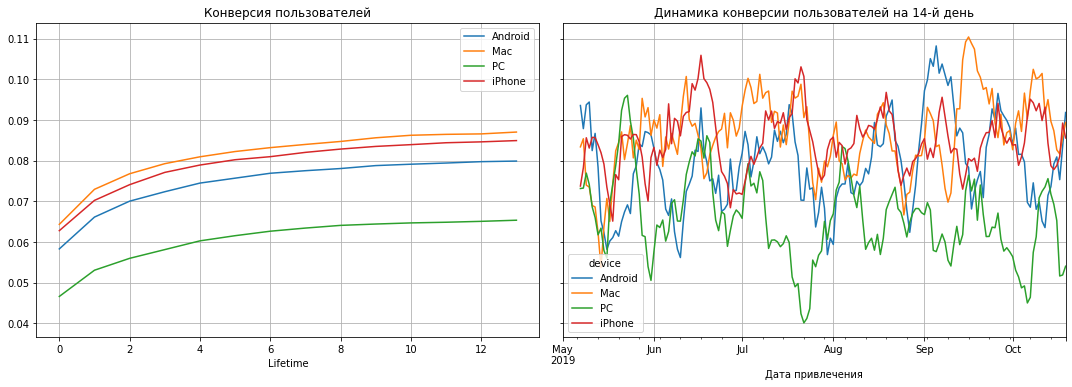

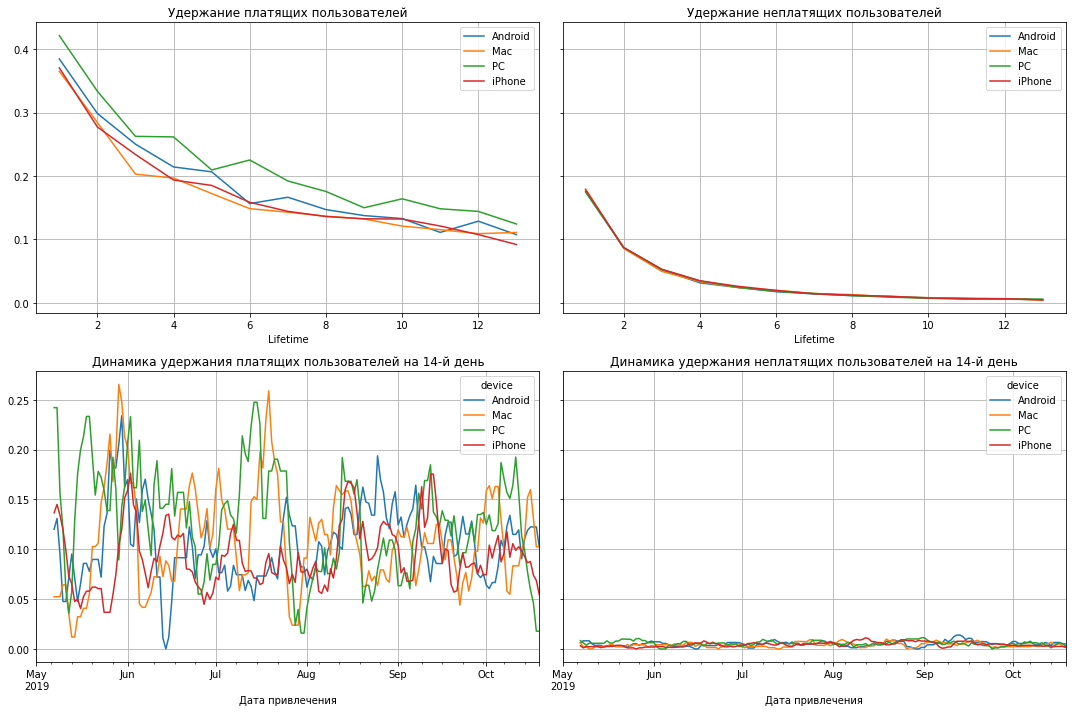

In [38]:
##изучим конверсию и удержания по девайсам 
dimensions = ['device']  

    
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days)

При изучении конверсии и удержания по устройствам мы наблюдаем низкую конверсию по пользователям с устройствами  PC и сильно меняющуюся динамику удержания платящих пользователей. Возможно причина кроется в технической ошибке.

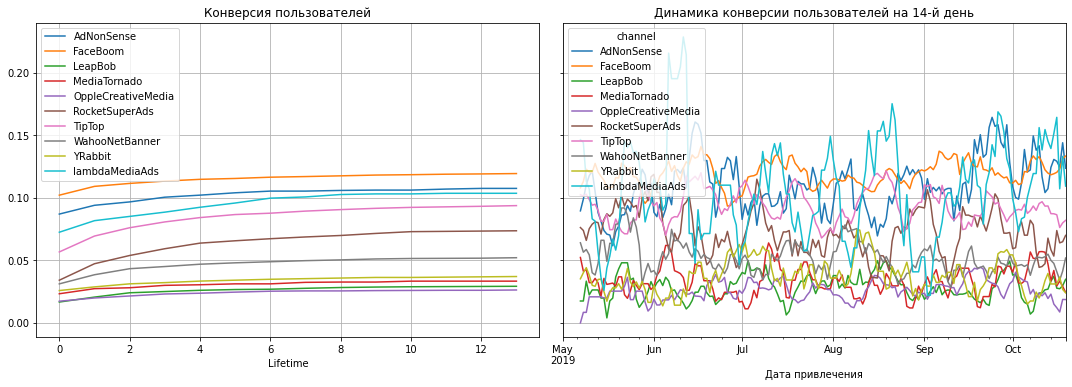

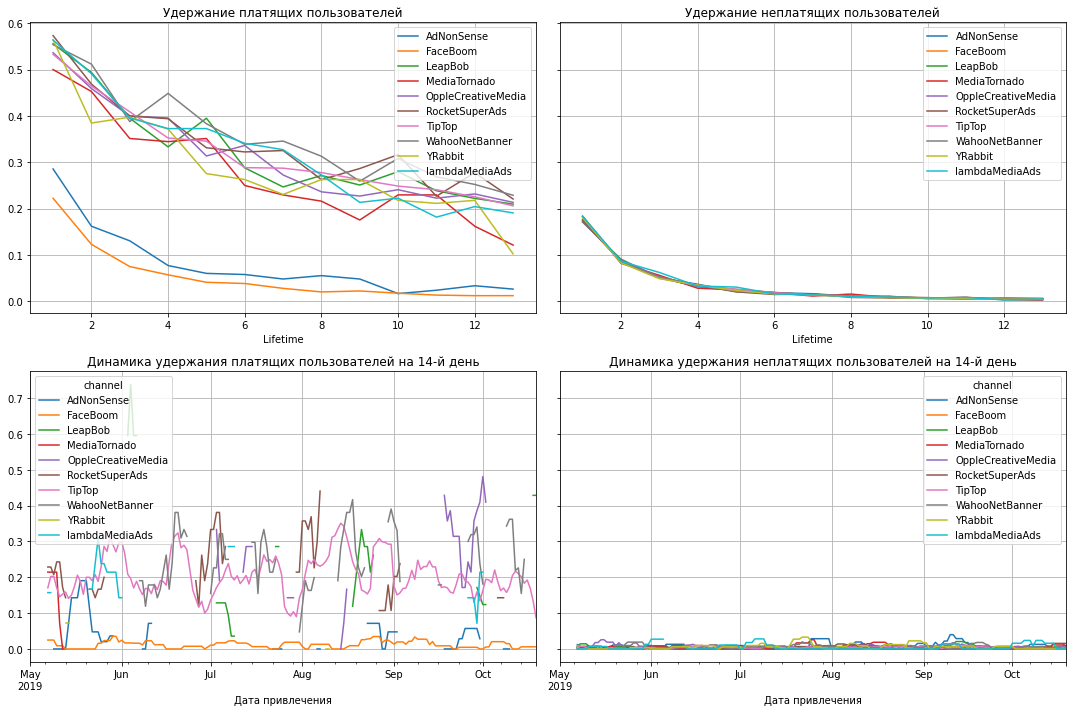

In [39]:
##изучим конверсию и удержания по каналам
dimensions = ['channel']  

    
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days)

Несмотря на высокую конверсию по каналу FaceBoom удержание платящих клиентов оставляет желать лучшего.

#### Вывод
Исходя из визуализаций по каналам привлечения мы наблюдаем эффективность всех каналов кроме Tiptop,FaceBoom,AdNonSense, помимо полученного убытка по каналу FaceBoom и AdNonSense низкая динамика удержания платящих пользователей. Отделу маркетинга следует проанализировать каким образом мы можем уменьшить стоимость рекламы в TipTop,FaceBoom,AdNonSense(возможно следует изменить настройки рекламной кампании). Возможно следует изменить основной источник и выбрать наиболее рентабельные каналы, например: YRabbit,MediaTornado,AdNonSense,RocketSuperAds.

# Шаг 6. Выводы
<a id=conclusion_id></a>
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.


Общая стоимость рекламной кампаний за весь период составила **105 497 USD.**
Большая часть расходов приходится на 2 канала привлечения клиентов: **TipTop 54 751.3 и FaceBoom 32 445.6**

При выполнении анализа LTV, CAC, ROI к концу периода было выявлено снижение доходов по пользователям с девайсом PC. Требуется выяснить природу данного снижения, так как оно может быть вызвано техническим сбоем приложения именно для этого девайса.

На основании изучении кампаний по странам, можно сделать вывод,что рынок по USA является нерентабельным для организации, следует значительно уменьшить издержки, либо увеличить стоимость приложения.

Также следует оптимизировать расходы на рекламные каналы Tiptop,FaceBoom,AdNonSense путем более детального анализа и выявления причин повышения стоимости. Расходы на вышеуказанные каналы оставить на том уровне,чтобы реклама оставалась рентабельной. Освободившиеся денежные средства можно вложить в рекламные кампании с меньшей стоимостью и высокой рентабельностью, например: YRabbit,MediaTornado,AdNonSense,RocketSuperAds.


In [43]:
display(retention_history)

cohort_size    0         1         2  \
payer channel        dt                                                 
False AdNonSense     2019-05-01           36  1.0  0.222222  0.000000   
                     2019-05-02           36  1.0  0.111111  0.083333   
                     2019-05-03           42  1.0  0.142857  0.095238   
                     2019-05-04           45  1.0  0.133333  0.066667   
                     2019-05-05           31  1.0  0.322581  0.064516   
...                                      ...  ...       ...       ...   
True  lambdaMediaAds 2019-10-13            2  1.0  1.000000  0.500000   
                     2019-10-14            1  1.0  0.000000  1.000000   
                     2019-10-15            3  1.0  0.666667  0.666667   
                     2019-10-16            1  1.0  1.000000  0.000000   
                     2019-10-18            2  1.0  1.000000  1.000000   

                                        3         4         5         6  \
payer channel        dt                                                   
False AdNonSense     2019-05-01  0.111111  0.027778  0.000000  0.027778   
                     2019-05-02  0.027778  0.027778  0.000000  0.055556   
                     2019-05-03  0.047619  0.023810  0.023810  0.047619   
                     2019-05-04  0.044444  0.022222  0.022222  0.000000   
                     2019-05-05  0.064516  0.032258  0.000000  0.032258   
...                                   ...       ...       ...       ...   
True  lambdaMediaAds 2019-10-13  0.000000  1.000000  0.500000  0.500000   
                     2019-10-14  0.000000  0.000000  0.000000  1.000000   
                     2019-10-15  0.666667  0.333333  0.333333  0.333333   
                     2019-10-16  1.000000  0.000000  0.000000  0.000000   
                     2019-10-18  1.000000  0.000000  0.000000  0.000000   

                                       7         8         9        10  \
payer channel        dt                                                  
False AdNonSense     2019-05-01  0.00000  0.000000  0.027778  0.000000   
                     2019-05-02  0.00000  0.055556  0.000000  0.000000   
                     2019-05-03  0.02381  0.000000  0.000000  0.000000   
                     2019-05-04  0.00000  0.000000  0.000000  0.000000   
                     2019-05-05  0.00000  0.000000  0.000000  0.000000   
...                                  ...       ...       ...       ...   
True  lambdaMediaAds 2019-10-13  0.00000  0.500000  0.000000  0.000000   
                     2019-10-14  0.00000  0.000000  1.000000  0.000000   
                     2019-10-15  0.00000  0.333333  0.000000  0.333333   
                     2019-10-16  1.00000  0.000000  0.000000  0.000000   
                     2019-10-18  0.50000  1.000000  0.500000  0.500000   

                                       11        12        13  
payer channel        dt                                        
False AdNonSense     2019-05-01  0.000000  0.000000  0.027778  
                     2019-05-02  0.055556  0.055556  0.027778  
                     2019-05-03  0.000000  0.000000  0.000000  
                     2019-05-04  0.000000  0.000000  0.000000  
                     2019-05-05  0.000000  0.000000  0.000000  
...                                   ...       ...       ...  
True  lambdaMediaAds 2019-10-13  0.000000  0.500000  0.000000  
                     2019-10-14  1.000000  0.000000  1.000000  
                     2019-10-15  0.333333  0.000000  0.666667  
                     2019-10-16  0.000000  0.000000  0.000000  
                     2019-10-18  0.500000  0.000000  0.500000  

[3082 rows x 15 columns]

In [44]:
retention_history.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3082 entries, (False, 'AdNonSense', Timestamp('2019-05-01 00:00:00')) to (True, 'lambdaMediaAds', Timestamp('2019-10-18 00:00:00'))
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cohort_size  3082 non-null   int64  
 1   0            3082 non-null   float64
 2   1            3082 non-null   float64
 3   2            3082 non-null   float64
 4   3            3082 non-null   float64
 5   4            3082 non-null   float64
 6   5            3082 non-null   float64
 7   6            3082 non-null   float64
 8   7            3082 non-null   float64
 9   8            3082 non-null   float64
 10  9            3082 non-null   float64
 11  10           3082 non-null   float64
 12  11           3082 non-null   float64
 13  12           3082 non-null   float64
 14  13           3082 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 379.3+ KB
